In [27]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
from IPython.display import display, HTML

In [28]:
def selecionar_aprovados(dados):

    df = dados.copy(deep=True)

    # Seleciona os 81 primeiros candidatos aprovados
    df.loc[df.loc[df["APROVADO DISCURSIVA"] == True].head(81).index, 'SITUAÇÃO PARCIAL'] = "Aprovado nas vagas de ampla concorrência"

    # Seleciona os candidatos aprovados PCD que ainda não foram incluídos
     
    df.loc[df.loc[(df['SITUAÇÃO PARCIAL'].isna()) & 
                  (df["SITUACAO OBJETIVA"] == "Aprovado PcD") &
                  (df["APROVADO DISCURSIVA"] == True)].head(9).index, 'SITUAÇÃO PARCIAL'] = "Aprovado nas vagas de cota PCD"

    # Caso não haja 9 candidatos aprovados PCD, completa com aprovados na Ampla
    if len(df[df['SITUAÇÃO PARCIAL'] == "Aprovado nas vagas de cota PCD"]) < 9:
        df.loc[df.loc[(df['SITUAÇÃO PARCIAL'].isna()) &
                      (df["APROVADO DISCURSIVA"] == True)].head(9 - len(df[df['SITUAÇÃO PARCIAL'] == "Aprovado nas vagas de cota PCD"])).index, 'SITUAÇÃO PARCIAL'] = "Aprovado nas vagas de ampla concorrência"

    df.loc[(df['SITUAÇÃO PARCIAL'].isna()) & 
           (df["APROVADO DISCURSIVA"] == True), 'SITUAÇÃO PARCIAL'] = "Cadastro de Reservas"

    df['SITUAÇÃO PARCIAL'] = df['SITUAÇÃO PARCIAL'].fillna('Reprovado na discursiva')
      
    # Retorna os 81 primeiros aprovados + os 9 primeiros aprovados PCD
    return df

In [29]:
def gerar_html_linha(row):
    return f'''<tr style="background-color: rgba({'193, 225, 193' if (row['SITUAÇÃO PARCIAL'] == "Aprovado nas vagas de ampla concorrência") | (row['SITUAÇÃO PARCIAL'] == "Aprovado nas vagas de cota PCD") else
     '255, 250, 160' if row['SITUAÇÃO PARCIAL'] == "Cadastro de Reservas" else 
     '250, 160, 160'},{'1' if row['POS'] % 2 == 0 else '0.8'});">
    <td>{row['POS']}</td>
    <td>{row['INSC_NUMB']}</td>
    <td>{row['NOME']}</td>
    <td>{row['TOTAL']}</td>
    <td>{'SIM' if row['IDOSO'] else 'NÃO'}</td>
    <td>{row['TOTAL DISCURSIVA'] if ~np.isnan(row['TOTAL DISCURSIVA']) else '-'}</td>
    <td>{row['P2']}</td>
    <td>{row['CD']}</td>
    <td>{row['DEV']}</td>
    <td>{row['BD']}</td>
    <td>{row['NASC'].strftime('%d/%m/%Y')}</td>
    <td>{'<b>▲ </b>' + str(row['POS OBJETIVA'] - row['POS']) if row['POS OBJETIVA'] > row['POS'] else 
         '-' if row['POS OBJETIVA'] == row['POS'] else
         '<b>▼ </b>' + str(row['POS'] - row['POS OBJETIVA'])}</td>
    <td>{row['SITUAÇÃO PARCIAL']}</td>
    </tr>'''

In [30]:
resultado_objetiva = pd.read_csv('./data/resultado-objetiva.csv', sep=";", index_col=['INSC_NUMB', 'NOME'])
resultado_discursiva = pd.read_csv('./data/resultado-discursiva.csv', sep=";", index_col=['INSC_NUMB', 'NOME'])

In [31]:
resultado_preliminar = resultado_objetiva.merge(resultado_discursiva, on=['INSC_NUMB', 'NOME'], how='left')

In [32]:
resultado_preliminar['TOTAL'] = resultado_preliminar['TOTAL OBJETIVA'] + resultado_preliminar['TOTAL DISCURSIVA'].fillna(value=0)
resultado_preliminar['APROVADO DISCURSIVA'] = resultado_preliminar['TOTAL DISCURSIVA'] >= 40
resultado_preliminar['NASC'] = pd.to_datetime(resultado_preliminar['NASC'], format='%d/%m/%Y')
today = datetime.today()
resultado_preliminar['IDADE'] = (today - resultado_preliminar['NASC']).astype('timedelta64[Y]')
resultado_preliminar['IDOSO'] = resultado_preliminar['IDADE'] >= 60

In [33]:
resultado_preliminar_ordenado = resultado_preliminar.sort_values(by=['APROVADO DISCURSIVA', 'TOTAL', 'IDOSO', 'TOTAL DISCURSIVA', 'P2', 'CD', 'DEV', 'BD', 'NASC'], 
                                               ascending=[False, False, False, False, False, False, False, False, True])

In [34]:
resultado_preliminar_ordenado = resultado_preliminar_ordenado.reset_index(drop=False)
resultado_preliminar_ordenado['POS'] = resultado_preliminar_ordenado.index + 1

In [35]:
resultado_preliminar_ordenado = selecionar_aprovados(resultado_preliminar_ordenado)

In [36]:
resultado_preliminar_ordenado['html_linha'] = resultado_preliminar_ordenado.apply(gerar_html_linha, axis=1)

In [37]:
render_html = '''<style>
table {
  border-collapse: collapse;
  font-size: 12px;
}
table, th, td {
  border: 1px solid black;
  text-align: center;
}
th {
  font-weight: bold;
  top: 0;
}
body {
  font-family: Arial, sans-serif;
}
thead { 
  display: table-header-group; 
}
@media print {
  tr {
    page-break-inside: avoid;
  }
}
@page {
  size: A3;
}
</style>
<h4><center>Resultado Preliminar - Tecnologia da Informação<br>Secretaria de Estado de Fazenda de Minas Gerais</center></h4>
Critérios de desempate:<br>
a) tiver idade igual ou superior a sessenta anos, nos termos do art. 27, parágrafo único, do Estatuto do Idoso;<br>
b) obtiver maior nota na Prova Escrita Discursiva;<br>
c) obtiver maior nota na Prova Escrita Objetiva II;<br>
d) obtiver maior número de acertos em Ciência de Dados;<br>
e) obtiver maior número de acertos em Desenvolvimento de Sistemas;<br>
f) obtiver maior número de acertos em Banco de Dados;<br>
g) tiver exercido a função de jurado, nos termos do art. 440 do Código de Processo Penal (não considerado nesta classificação);<br>
h) persistindo o empate, observar-se-á o critério de maior idade.
<table style="margin-top: 10px;">
  <colgroup>
    <col style="width: 7%;">
    <col style="width: 7%;">
    <col style="width: 24%;">
    <col style="width: 5%;">
    <col style="width: 4%;">
    <col style="width: 4%;">
    <col style="width: 4%;">
    <col style="width: 4%;">
    <col style="width: 4%;">
    <col style="width: 4%;">
    <col style="width: 9%;">
    <col style="width: 8%;">
    <col style="width: 16%;">
  </colgroup>
  <thead>
<tr>
<th rowspan="2">Posição preliminar</th>
<th rowspan="2">Inscrição</th>
<th rowspan="2">Nome</th>
<th rowspan="2">Nota total preliminar</th>
<th colspan="7">Critérios de desempate</th>
<th rowspan="2">Variação de posição</th>
<th rowspan="2">Situação preliminar</th>
</tr>
<tr>
    <th>Idoso</th>
    <th>P3</th>
    <th>P2</th>
    <th>CD</th>
    <th>DS</th>
    <th>BD</th>
    <th>Data de Nascimento</th>
</tr>
</thead>'''

for index, row in resultado_preliminar_ordenado.iterrows():
    render_html += row['html_linha']

render_html += '''</table>'''

In [38]:
with open('./output/resultado_preliminar.html', 'w') as f:
    f.write(render_html)

In [39]:
display(HTML(render_html))

In [70]:
materias = ['PT','RLM','DALE','DCDH','DCDE','DP','DT','CONT','EMF','ING','CD','DEV','BD','IT','SEG','LTE','P1','P2','TOTAL OBJETIVA']

resultados = []
for materia in materias:
    corr = resultado_preliminar_ordenado['APROVADO DISCURSIVA'].corr(resultado_preliminar_ordenado[materia])
    resultados.append((materia, corr))

# Ordenar a lista de resultados em ordem decrescente de correlação
resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)

# Imprimir os resultados ordenados
print('Correlação entre aprovados e nota das disciplinas')
for materia, corr in resultados_ordenados:
    print(f'{materia}: {corr}')

Correlação entre aprovados e nota das disciplinas
TOTAL OBJETIVA: 0.4527059400392158
P2: 0.4278984424909025
P1: 0.3600443703117609
SEG: 0.308830496649206
RLM: 0.2983606431162569
BD: 0.23343605448673854
ING: 0.22437853817398265
DT: 0.2158268228250779
DALE: 0.2086200811152516
DCDH: 0.19459666168191622
DP: 0.18404391862999392
CONT: 0.16554706388607104
DEV: 0.16249801084038226
LTE: 0.16087577110072324
DCDE: 0.15685165054796116
EMF: 0.15310658100604785
IT: 0.14690387376497402
PT: 0.1221739748974851
CD: 0.0421262956152828


In [71]:
materias = ['PT','RLM','DALE','DCDH','DCDE','DP','DT','CONT','EMF','ING','CD','DEV','BD','IT','SEG','LTE','P1','P2','TOTAL OBJETIVA']

resultados = []
for materia in materias:
    corr = resultado_preliminar_ordenado['TOTAL DISCURSIVA'].corr(resultado_preliminar_ordenado[materia])
    resultados.append((materia, corr))

# Ordenar a lista de resultados em ordem decrescente de correlação
resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)

# Imprimir os resultados ordenados
print('Correlação entre nota na discursiva e nota das disciplinas')
for materia, corr in resultados_ordenados:
    print(f'{materia}: {corr}')

Correlação entre nota na discursiva e nota das disciplinas
TOTAL OBJETIVA: 0.3455966128113414
P2: 0.3130559704797488
P1: 0.2626161979418715
DT: 0.23477354518003665
ING: 0.21783772673234494
CD: 0.21023005255574137
RLM: 0.20498977217988865
DCDH: 0.1821767319577293
DCDE: 0.16685063016242616
CONT: 0.16377394945982568
DALE: 0.15430447843737477
DP: 0.12942158956438699
LTE: 0.11627747521718348
DEV: 0.11377885777637431
SEG: 0.10928966738393171
BD: 0.09406218509147854
IT: 0.07980812820672861
PT: 0.014224770449991661
EMF: -0.04105517059575454


In [99]:
import matplotlib.pyplot as plt
import plotly.express as px

v1 = 'TOTAL DISCURSIVA'
v2 = 'TOTAL OBJETIVA'
# Plotar o gráfico de dispersão
# plt.scatter(resultado_preliminar_ordenado[v1], resultado_preliminar_ordenado[v2])

fig = px.scatter(resultado_preliminar_ordenado, x=v1, y=v2, color='SITUAÇÃO PARCIAL', opacity=0.5)

fig.update_layout(width=1000, height=700)

fig.show()

In [100]:
import matplotlib.pyplot as plt
import plotly.express as px

v1 = 'TOTAL DISCURSIVA'
v2 = 'P2'
# Plotar o gráfico de dispersão
# plt.scatter(resultado_preliminar_ordenado[v1], resultado_preliminar_ordenado[v2])

fig = px.scatter(resultado_preliminar_ordenado, x=v1, y=v2, color='SITUAÇÃO PARCIAL', opacity=0.5)

fig.update_layout(width=1000, height=700)

fig.show()

In [101]:
import matplotlib.pyplot as plt
import plotly.express as px

v1 = 'TOTAL DISCURSIVA'
v2 = 'P1'
# Plotar o gráfico de dispersão
# plt.scatter(resultado_preliminar_ordenado[v1], resultado_preliminar_ordenado[v2])

fig = px.scatter(resultado_preliminar_ordenado, x=v1, y=v2, color='SITUAÇÃO PARCIAL', opacity=0.5)

fig.update_layout(width=1000, height=700)

fig.show()

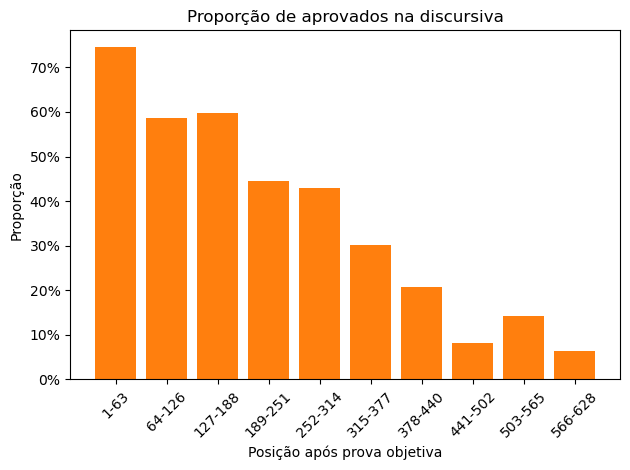

In [110]:
import matplotlib.ticker as mticker

# Definir os intervalos
intervals = [
    (1, 63),
    (64, 126),
    (127, 188),
    (189, 251),
    (252, 314),
    (315, 377),
    (378, 440),
    (441, 502),
    (503, 565),
    (566, 628)
]

# Inicializar uma lista para armazenar as proporções
proporcoes = []

# Iterar sobre os intervalos
for interval in intervals:
    # Filtrar o DataFrame dentro do intervalo
    filtro = (resultado_preliminar_ordenado['POS OBJETIVA'] >= interval[0]) & (resultado_preliminar_ordenado['POS OBJETIVA'] <= interval[1])
    df_intervalo = resultado_preliminar_ordenado[filtro]

    # Calcular a proporção onde 'TOTAL DISCURSIVA' é diferente de NaN
    proporcao = df_intervalo['TOTAL DISCURSIVA'].notna().mean()
    proporcoes.append(proporcao)

# Criar um DataFrame com as proporções
df_proporcoes = pd.DataFrame({'Intervalo': [f'{interval[0]}-{interval[1]}' for interval in intervals], 'Proporção': proporcoes})

fig, ax = plt.subplots()
ax.bar(df_proporcoes['Intervalo'], df_proporcoes['Proporção'])

# Definir a formatação em percentual no eixo Y
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Plotar o gráfico de barras
plt.bar(df_proporcoes['Intervalo'], df_proporcoes['Proporção'])
plt.xlabel('Posição após prova objetiva')
plt.ylabel('Proporção')
plt.title('Proporção de aprovados na discursiva')
plt.xticks(rotation=45)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [115]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

x = np.arange(0, 20, 0.5)
width = 0.2

fig = make_subplots(rows=2, cols=2, subplot_titles=('Questão 1', 'Questão 2', 'Questão 3', 'Questão 4'))


hist1, edges1 = np.histogram(resultado_preliminar_ordenado['Q1'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges1[:-1], y=hist1, name='Questão 1'), row=1, col=1)

# Gráfico 2
hist2, edges2 = np.histogram(resultado_preliminar_ordenado['Q2'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges2[:-1], y=hist2, name='Questão 2'), row=1, col=2)

# Gráfico 3
hist3, edges3 = np.histogram(resultado_preliminar_ordenado['Q3'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges3[:-1], y=hist3, name='Questão 3'), row=2, col=1)

# Gráfico 4
hist4, edges4 = np.histogram(resultado_preliminar_ordenado['Q4'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges4[:-1], y=hist4, name='Questão 4'), row=2, col=2)

# Atualizar layout
fig.update_layout(height=600, width=800, showlegend=False)

# Exibir a imagem
fig.show()

In [117]:
hist, edges = np.histogram(resultado_preliminar_ordenado['TOTAL DISCURSIVA'], bins=np.arange(40, 81, 0.5))

# Criar figura
fig = go.Figure(data=[go.Bar(x=edges[:-1], y=hist)])

# Configurar layout
fig.update_layout(
    title='Histograma - TOTAL DISCURSIVA',
    xaxis_title='Valores',
    yaxis_title='Frequência',
    bargap=0.01
)

# Exibir o histograma
fig.show()

In [118]:
# Selecionar as colunas desejadas
colunas = ["Q1", "Q2", "Q3", "Q4", "TOTAL DISCURSIVA"]

# Gerar estatísticas básicas
estatisticas = resultado_preliminar_ordenado[colunas].describe()

# Exibir as estatísticas
print(estatisticas)


               Q1          Q2          Q3          Q4  TOTAL DISCURSIVA
count  226.000000  226.000000  226.000000  226.000000        226.000000
mean    16.756637   15.141593   11.884956    8.294248         52.077434
std      3.674607    4.897831    4.200005    3.903094          8.369228
min      5.500000    0.000000    0.000000    0.000000         40.000000
25%     15.000000   12.000000    8.000000    5.500000         45.000000
50%     18.000000   16.000000   12.000000    8.000000         51.500000
75%     20.000000   20.000000   16.000000   11.500000         57.500000
max     20.000000   20.000000   20.000000   18.000000         76.000000


In [123]:
# Filtrar os valores não NaN da coluna "TOTAL DISCURSIVA"
df_filtrado = resultado_preliminar_ordenado.dropna(subset=["TOTAL DISCURSIVA"])

# Selecionar as colunas desejadas
colunas = ["Q1", "Q2", "Q3", "Q4"]

# Contar quantas notas 20 cada pessoa teve
df_filtrado["Notas 20"] = df_filtrado[colunas].eq(20).sum(axis=1)

# Criar histograma
hist, edges = np.histogram(df_filtrado["Notas 20"], bins=np.arange(0, len(colunas)+2, 1))

# Criar figura
fig = go.Figure(data=[go.Bar(x=edges[:-1], y=hist)])

# Configurar layout
fig.update_layout(
    title="Histograma - Quantidade de notas 20",
    xaxis_title="Número de notas 20",
    yaxis_title="Frequência"
)

# Exibir o histograma
fig.show()

C:\Users\rafae\AppData\Local\Temp\ipykernel_10604\1308918806.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
candidatos_aprovados = resultado_preliminar_ordenado[resultado_preliminar_ordenado['SITUAÇÃO PRELIMINAR'] == 'Aprovado']

# Criar histograma
fig = go.Figure(data=[go.Histogram(x=candidatos_aprovados['idade'])])

# Configurar layout
fig.update_layout(
    title='Histograma - Idade dos candidatos aprovados',
    xaxis_title='Idade',
    yaxis_title='Frequência'
)

# Exibir o histograma
fig.show()